# FomulaBEAT

変更点
- デコーダのみで学習させる


In [1]:
version = '02-2'
model_dir = './model/' + version
data_path = 'data/eq02.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split('=')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['8+0', '5+2', '5+1'] ['8', '7', '6']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# 辞書と逆辞書を構築
vocab_src = build_vocab(src_data)
vocab_tgt = build_vocab(tgt_data)

print(vocab_tgt)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13}


In [9]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    indexes = indexes.tolist()
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0], vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1], vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  1, 14,  7, 13])
Output: tensor([12,  8, 13])
元に戻した文章
Input: 1+7
Output: 8


In [10]:
batch_size = 128
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [11]:
len(train_data)

8000

Transoformerの設定

In [12]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [13]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size_src: int, vocab_size_tgt: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding_src = TokenEmbedding(vocab_size_src, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        # encoder_layer = TransformerEncoderLayer(
        #     d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        # )
        # self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, embedding_size)
        decoder_layer = TransformerDecoderLayer(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output = nn.Linear(embedding_size, vocab_size_tgt)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    # def encode(self, src: Tensor, mask_src: Tensor):
    #     return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

In [14]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [15]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [16]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [17]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [18]:
print(model)

Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 4)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
 

In [19]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


22 層

層名: token_embedding_src.embedding.weight
形状: torch.Size([15, 4])
値: Parameter containing:
tensor([[ 0.0978, -0.4036,  0.2521,  0.4729],
        [ 0.1873,  0.3459,  0.1519,  0.1750],
        [ 0.5460, -0.3835, -0.4566,  0.3992],
        [ 0.2813,  0.4263,  0.1301,  0.0320],
        [ 0.1746,  0.2904,  0.3647, -0.3299],
        [ 0.2653, -0.0107,  0.1830,  0.3038],
        [-0.0391,  0.2798,  0.4445, -0.0364],
        [-0.2663,  0.3617,  0.0936,  0.1165],
        [-0.0730,  0.3463, -0.5282,  0.1911],
        [ 0.1667, -0.4848,  0.1185, -0.2437],
        [ 0.2746, -0.0719, -0.2043, -0.2651],
        [ 0.2533, -0.0254,  0.3413,  0.3232],
        [-0.5607, -0.4318, -0.4676, -0.5088],
        [-0.4003,  0.1326,  0.4594, -0.5619],
        [ 0.4679, -0.1612,  0.2693,  0.0245]], device='cuda:0', requires_grad=True)

層名: token_embedding_tgt.embedding.weight
形状: torch.Size([14, 4])
値: Parameter containing:
tensor([[-0.1236,  0.3986,  0.0314, -0.4225],
        [ 0.2829, -0.1505, -0.4358,  0.

## 学習実行

In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

学習したモデルの保存

In [108]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [109]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts, vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding_src(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [ ]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '4+3'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

## モデルの動作を分析

In [20]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 4)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
 

In [21]:
tokenized = convert_text_to_indexes('9+4', vocab_src)
print("Tokenized input:", tokenized)


Tokenized input: [12, 9, 14, 4, 13]


In [22]:
tokenized_tensor = torch.LongTensor(tokenized).unsqueeze(1).to(device)
embedding_output = loaded_model.token_embedding_src(tokenized_tensor)
print("Embedding output:", embedding_output)


Embedding output: tensor([[[-1.1038, -0.8104, -0.3543,  0.2094]],

        [[-0.5716, -0.8495,  1.0736, -0.7472]],

        [[-1.7107,  1.2094, -0.8452, -0.2918]],

        [[ 1.2023,  0.3225,  0.4513, -0.7417]],

        [[-0.4569,  1.4827, -1.5845, -0.6838]]], device='cuda:0', grad_fn=<MulBackward0>)


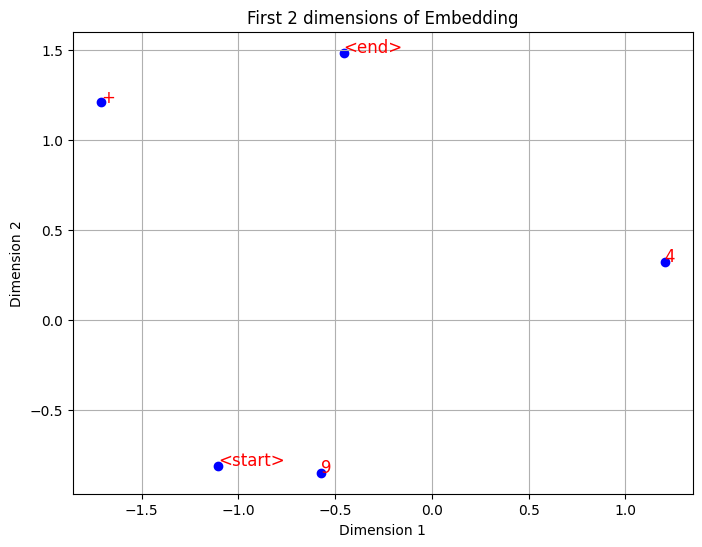

In [23]:
import matplotlib.pyplot as plt

# 埋め込みデータの最初の2次元を散布図として可視化
embedding_2d = embedding_output[:, 0, :2].detach().cpu().numpy()

# 散布図の作成
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], color='blue')

# 対応するトークンラベル
tokens = ['<start>', '9', '+', '4', '<end>']

# 各トークンにラベルを付ける
for i, token in enumerate(tokens):
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], token, fontsize=12, color='red')

plt.title('First 2 dimensions of Embedding')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


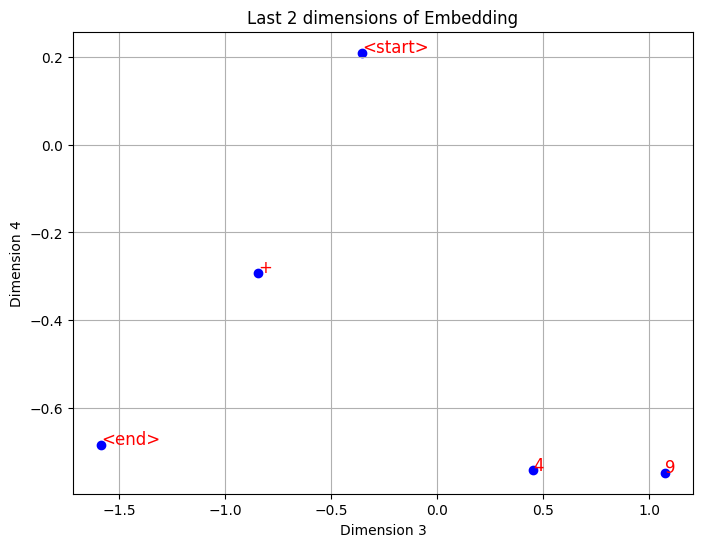

In [24]:
# 埋め込みデータの後ろの2次元を可視化
embedding_last_2d = embedding_output[:, 0, 2:].detach().cpu().numpy()

# 散布図の作成
plt.figure(figsize=(8, 6))
plt.scatter(embedding_last_2d[:, 0], embedding_last_2d[:, 1], color='blue')

# 各トークンにラベルを付ける
for i, token in enumerate(tokens):
    plt.text(embedding_last_2d[i, 0], embedding_last_2d[i, 1], token, fontsize=12, color='red')

plt.title('Last 2 dimensions of Embedding')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 4')
plt.grid(True)
plt.show()


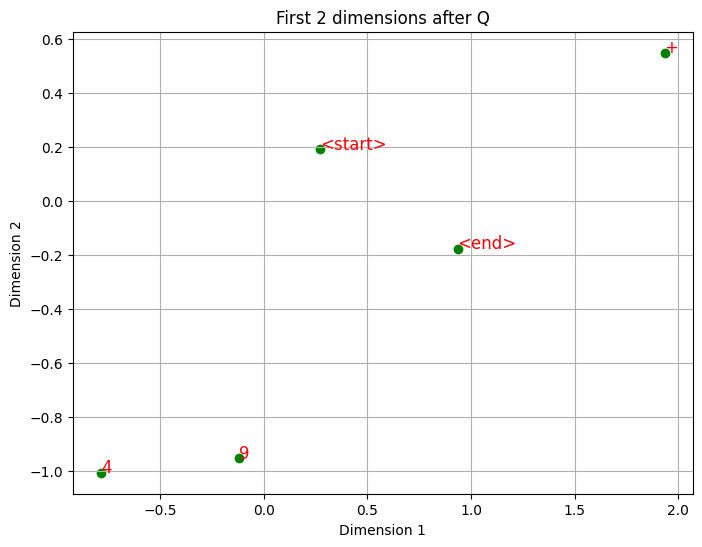

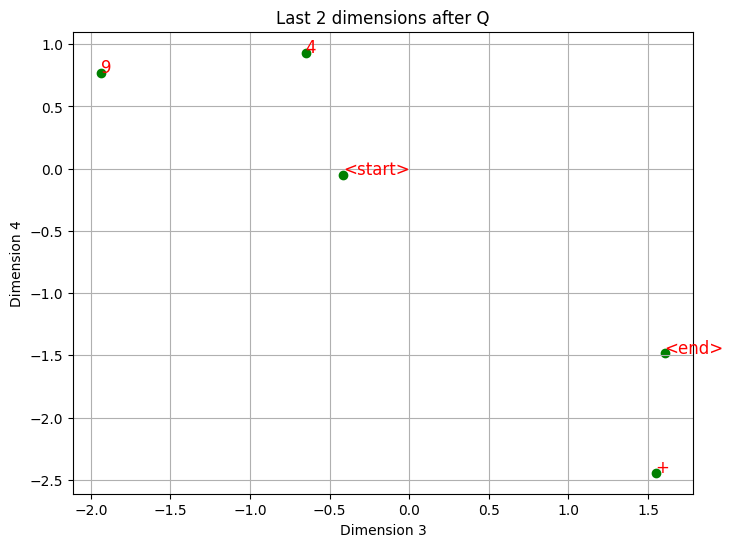

In [25]:
# Q行列を取り出して、埋め込みに適用
Q = loaded_model.transformer_decoder.layers[0].self_attn.in_proj_weight[:embedding_size, :]
q_output = torch.matmul(Q, embedding_output.squeeze(1).T).T

# 最初の2次元を可視化
q_first_2d = q_output[:, :2].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(q_first_2d[:, 0], q_first_2d[:, 1], color='green')

for i, token in enumerate(tokens):
    plt.text(q_first_2d[i, 0], q_first_2d[i, 1], token, fontsize=12, color='red')

plt.title('First 2 dimensions after Q')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# 後ろの2次元を可視化
q_last_2d = q_output[:, 2:].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(q_last_2d[:, 0], q_last_2d[:, 1], color='green')

for i, token in enumerate(tokens):
    plt.text(q_last_2d[i, 0], q_last_2d[i, 1], token, fontsize=12, color='red')

plt.title('Last 2 dimensions after Q')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 4')
plt.grid(True)
plt.show()


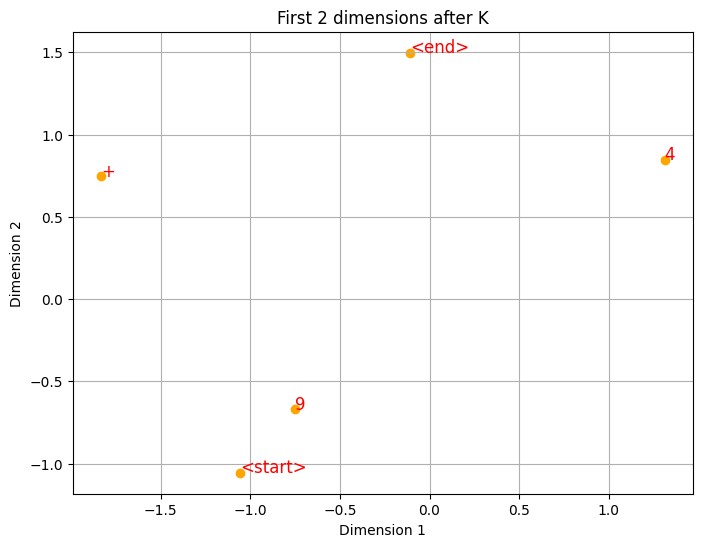

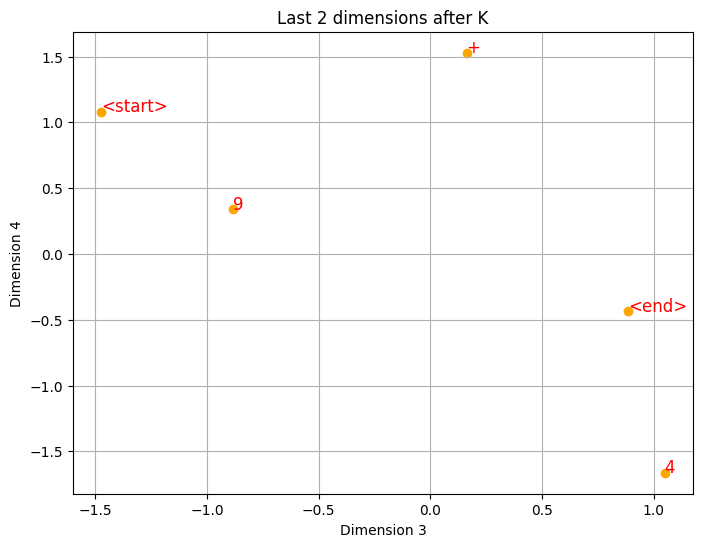

In [26]:
# K行列とV行列を取り出して、埋め込みに適用
K = loaded_model.transformer_decoder.layers[0].self_attn.in_proj_weight[embedding_size:2*embedding_size, :]
V = loaded_model.transformer_decoder.layers[0].self_attn.in_proj_weight[2*embedding_size:, :]

k_output = torch.matmul(K, embedding_output.squeeze(1).T).T
v_output = torch.matmul(V, embedding_output.squeeze(1).T).T

# Kの最初の2次元を可視化
k_first_2d = k_output[:, :2].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(k_first_2d[:, 0], k_first_2d[:, 1], color='orange')

for i, token in enumerate(tokens):
    plt.text(k_first_2d[i, 0], k_first_2d[i, 1], token, fontsize=12, color='red')

plt.title('First 2 dimensions after K')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# Kの後ろの2次元を可視化
k_last_2d = k_output[:, 2:].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(k_last_2d[:, 0], k_last_2d[:, 1], color='orange')

for i, token in enumerate(tokens):
    plt.text(k_last_2d[i, 0], k_last_2d[i, 1], token, fontsize=12, color='red')

plt.title('Last 2 dimensions after K')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 4')
plt.grid(True)
plt.show()


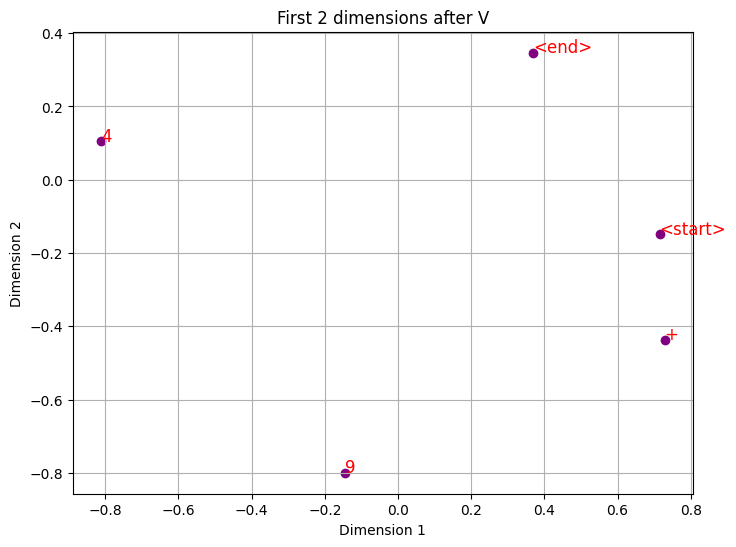

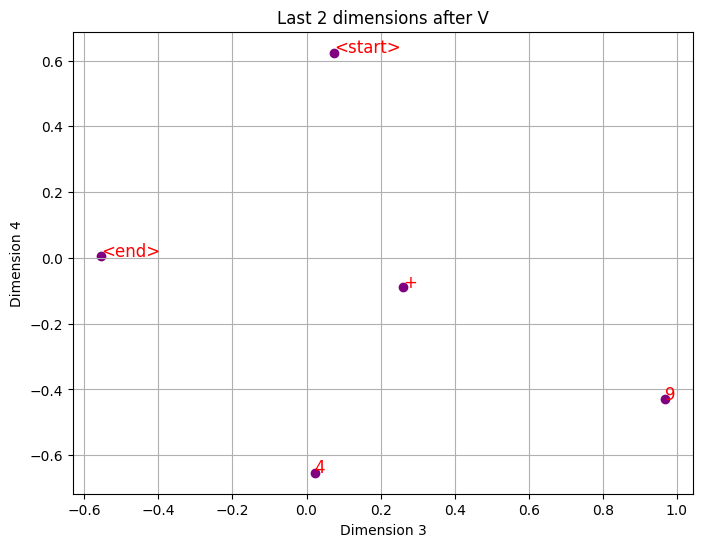

In [27]:

# Vの最初の2次元を可視化
v_first_2d = v_output[:, :2].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(v_first_2d[:, 0], v_first_2d[:, 1], color='purple')

for i, token in enumerate(tokens):
    plt.text(v_first_2d[i, 0], v_first_2d[i, 1], token, fontsize=12, color='red')

plt.title('First 2 dimensions after V')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# Vの後ろの2次元を可視化
v_last_2d = v_output[:, 2:].detach().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(v_last_2d[:, 0], v_last_2d[:, 1], color='purple')

for i, token in enumerate(tokens):
    plt.text(v_last_2d[i, 0], v_last_2d[i, 1], token, fontsize=12, color='red')

plt.title('Last 2 dimensions after V')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 4')
plt.grid(True)
plt.show()


In [36]:
def plot_scatter(data, tokens, title, x_label, y_label):
    data_2d = data[:, :2].detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2d[:, 0], data_2d[:, 1], color='blue')

    # 対応するトークンラベル
    for i, token in enumerate(tokens):
        plt.text(data_2d[i, 0], data_2d[i, 1], token, fontsize=12, color='red')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()



In [54]:

def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)

def create_mask(src, tgt, PAD_IDX):
    mask_src = torch.zeros((src.shape[0], src.shape[0]), device=src.device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(tgt.shape[0])
    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    print("Source input:", src)
    embedding_output = model.token_embedding_src(src)

    print("Embedding output (source):", embedding_output)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(embedding_output)
    print("Memory (source):", memory)
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

        # QKVの計算
        decoder_layer = model.transformer_decoder.layers[0]
        in_proj_weight = decoder_layer.self_attn.in_proj_weight
        in_proj_bias = decoder_layer.self_attn.in_proj_bias

        # Q, K, V の分割
        embedding_size = model.token_embedding_src.embedding.embedding_dim
        Q_weight = in_proj_weight[:embedding_size, :]
        K_weight = in_proj_weight[embedding_size:2*embedding_size, :]
        V_weight = in_proj_weight[2*embedding_size:, :]

        # バイアスの分割
        Q_bias = in_proj_bias[:embedding_size]
        K_bias = in_proj_bias[embedding_size:2*embedding_size]
        V_bias = in_proj_bias[2*embedding_size:]

        # Positional Encoding 後の埋め込みを用いて Q, K, V を計算
        positional_output = model.positional_encoding(model.token_embedding_src(ys))
        positional_output = torch.cat((memory, positional_output), dim=0)
        print(f"{i}Positional Encoding output:", positional_output)

        
        Q = torch.matmul(positional_output.squeeze(1), Q_weight.T) + Q_bias
        K = torch.matmul(positional_output.squeeze(1), K_weight.T) + K_bias
        V = torch.matmul(positional_output.squeeze(1), V_weight.T) + V_bias

        print(f"{i}Q:", Q)
        print(f"{i}K:", K)
        print(f"{i}V:", V)

        # Attention の計算
        d_k = Q.size(-1)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        print(f"Attention scores:", attention_scores)
        print(f"{i}Attention output:", attention_output)
        
        # 1. Attention 後の Linear1, Dropout, Linear2 の計算
        # Attention 出力を first linear layer (Linear1) に通す
        linear1_weight = decoder_layer.linear1.weight
        linear1_bias = decoder_layer.linear1.bias

        linear1_output = torch.matmul(attention_output, linear1_weight.T) + linear1_bias
        print("Linear1 output:", linear1_output)

        # Dropout を適用
        dropout_output = F.dropout(linear1_output, p=0.1, training=loaded_model.training)
        print("Dropout output:", dropout_output)

        # Second linear layer (Linear2) に通す
        linear2_weight = decoder_layer.linear2.weight
        linear2_bias = decoder_layer.linear2.bias

        linear2_output = torch.matmul(dropout_output, linear2_weight.T) + linear2_bias
        print("Linear2 output:", linear2_output)

        # 2. LayerNorm の適用
        # Norm1 の適用
        norm1_output = decoder_layer.norm1(attention_output + linear2_output)
        print("Norm1 output:", norm1_output)

        # Norm2 の適用（通常は MHA の出力の後に適用される）
        # ここではすでに計算済みの attention_output に適用
        norm2_output = decoder_layer.norm2(norm1_output)
        print("Norm2 output:", norm2_output)

        # Norm3 の適用（完全な層の後の最終正規化）
        norm3_output = decoder_layer.norm3(norm2_output)
        print("Norm3 output:", norm3_output)

        # 3. 最終出力層 (output Linear layer)
        # output層を通して、最終的な出力を得る
        output_linear_weight = loaded_model.output.weight
        output_linear_bias = loaded_model.output.bias

        final_output = torch.matmul(norm3_output, output_linear_weight.T) + output_linear_bias
        print("Final output:", final_output)



        # デコード処理
        output = model.decode(ys, memory, mask_tgt)
        print(f"{i}Decoder output:", output)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])

        print("Decoder output:", output)

        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        print("Next word:", next_word)
        print("Next word:", convert_indexes_to_text(torch.LongTensor([next_word]), vocab=vocab_tgt))


        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys

# 最終的なトークンの生成を行う関数
def translate(model, text, vocab_src, vocab_tgt, seq_len_tgt, START_IDX, END_IDX):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts, vocab=vocab_tgt)

seq_len_tgt = max([len(x[1]) for x in train_data])
text = '4+9'

# 翻訳を実行
translation = translate(
    model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")


Source input: tensor([[12],
        [ 4],
        [14],
        [ 9],
        [13]], device='cuda:0')
Embedding output (source): tensor([[[-1.1038, -0.8104, -0.3543,  0.2094]],

        [[ 1.2023,  0.3225,  0.4513, -0.7417]],

        [[-1.7107,  1.2094, -0.8452, -0.2918]],

        [[-0.5716, -0.8495,  1.0736, -0.7472]],

        [[-0.4569,  1.4827, -1.5845, -0.6838]]], device='cuda:0', grad_fn=<MulBackward0>)
Memory (source): tensor([[[-1.1038,  0.1896, -0.3543,  1.2094]],

        [[ 2.0437,  0.8628,  0.4613,  0.2582]],

        [[-0.8014,  0.7932, -0.8252,  0.7080]],

        [[-0.4305, -1.8395,  1.1036,  0.2524]],

        [[-1.2137,  0.8290, -1.5445,  0.3154]]], device='cuda:0', grad_fn=<AddBackward0>)
0Positional Encoding output: tensor([[[-1.1038,  0.1896, -0.3543,  1.2094]],

        [[ 2.0437,  0.8628,  0.4613,  0.2582]],

        [[-0.8014,  0.7932, -0.8252,  0.7080]],

        [[-0.4305, -1.8395,  1.1036,  0.2524]],

        [[-1.2137,  0.8290, -1.5445,  0.3154]],

        